# **Healthcare Analytics: Appointment No-Show \& Cancellation Prediction**
## **Binary Classification Project**

### **Project Overview**
This project focuses on developing a predictive analytics model to determine whether a scheduled healthcare appointment will result in a **successful visit** or a **failure outcome**, defined as either a **cancellation** or a **no-show**.

Accurate prediction of appointment failures is crucial for healthcare operations management. Missed appointments result in:

- Underutilized clinical resources  
- Increased patient wait times  
- Reduced provider productivity  
- Higher operational costs  
- Delays in diagnosis and treatment  

By leveraging machine learning and historical appointment-level data, this project aims to support proactive decision-making, enabling healthcare organizations to reduce no-shows through targeted interventions such as reminders, strategic overbooking, or personalized outreach.

---

### **Objective**
We formulate this as a **binary classification problem**, where the target variable is defined as:

\[
\{SUCCESS} = 0   
[Where APT_STATUS = CheckedIN, CheckedOUT, CONFIRMED
or Qualifying flag = 1]
\]

\[
\{NOT\_SUCCESS} = 1  
[Where APT_STATUS = No Show, Canceled
or Qualifying Flag = 0]
\]

Where:

- \(0 =\) Patient attended as scheduled  
- \(1 =\) Appointment was canceled or marked as a no-show  

The primary objective is to:

- Build a robust and interpretable predictive model  
- Identify key drivers of cancellations and no-shows  
- Provide operational insights supporting data-driven scheduling decisions  

---

### **Key Components of the Analysis**
- **Data Profiling & Preprocessing**: Cleaning, deduplication, missing value handling, normalization, and temporal feature preparation  
- **Feature Engineering**: Variables related to patient behavior, time-of-day/week patterns, appointment type, demographics, and historical adherence  
- **Model Development**: Logistic Regression, Decision Trees, Random Forests, Gradient Boosting Models (XGBoost, LightGBM), and Neural Networks  
- **Model Evaluation**: ROC-AUC, precision, recall, F1-score, confusion matrix, and cost-based evaluation  
- **Explainability**: SHAP values, feature importance, and partial dependence plots  
- **Deployment Pipeline**: Modular workflow for real-time or batch prediction in healthcare systems  

---

### **Business Value**
The predictive model enables healthcare organizations to:

- Reduce appointment no-show rates  
- Improve scheduling efficiency and resource utilization  
- Optimize provider productivity  
- Minimize operational waste  
- Enhance continuity of care and patient satisfaction  

---

### **Team Members (Placeholders)**
- Nandeesh Handral Shivakumar
- Michael Melaku
- Aishwarya Kona  
- Lauren Woo  
- Yixiao Shen  

In [ ]:
# Google Drive mounting removed for local execution


In [3]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


---
## 1. Import Libraries

In [4]:
# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    mean_squared_error, mean_absolute_error, r2_score
)

# Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

# Calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# SHAP
import shap

# Model persistence
import pickle
import joblib

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


---
## 2. Load and Stack Multiple Datasets

In [ ]:
# Load the 4 sample datasets
# Assuming files are named: sample_a.xlsx, sample_b.xlsx, sample_c.xlsx, sample_d.xlsx
datasets = []

file_names = [
    'data/Data_part_a.csv',
    'data/Data_part_b.csv',
    'data/Data_part_c.csv',
    'data/Data_part_d.csv'
]

for file in file_names:
    try:
        df = pd.read_csv(file)
        datasets.append(df)
        print(f"✓ Loaded {file}: {df.shape[0]} rows, {df.shape[1]} columns")
    except FileNotFoundError:
        print(f"⚠ Warning: {file} not found. Skipping...")

df_full = pd.concat(datasets, axis=0, ignore_index=True)

print("\n" + "="*60)
print(f"Combined Dataset Shape: {df_full.shape}")
print(f"Total Rows: {df_full.shape[0]:,}")
print(f"Total Columns: {df_full.shape[1]}")
print("="*60)

In [6]:
# Display first few rows
df_full.head()

,UNIQUE_ID,ENCNTR,APPT,AGE,SEX,LANGUAGE,ZIPCODE3,APPT_STATUS,QUALIFYING_FLAG,LEAD_TIME_DAYS,...,DURATION,APPT_TYPE_CODE,MEDICAL_SERVICE_CODE,SERVICE_LINE_USED,ENCNTR_TYPE,FACILITY_CODE,NURSE_UNIT_CODE,ATTENDING_PHYSICIAN,REFERRING_PHYSICIAN,PRIMARY_PLAN_TYPE
0,PERSONID_1,ENCOUNTER_1,APPT_1,57,Female,English,900.0,CHECKED OUT,1,28,...,30,1056.0,5740,Orthopaedics,Outpatient,1,639.0,PHYSICIAN_1,PHYSICIAN_245,MGD EPO
1,PERSONID_1,ENCOUNTER_2,APPT_2,57,Female,English,900.0,CHECKED OUT,1,77,...,15,8655.0,5740,Orthopaedics,Outpatient,2,153.0,PHYSICIAN_1,SELF REFERRED,MGD EPO
2,PERSONID_2,ENCOUNTER_3,APPT_3,55,Female,English,918.0,CHECKED OUT,1,6,...,30,1056.0,5740,Orthopaedics,Outpatient,1,6074.0,PHYSICIAN_2,SELF REFERRED,MGD PPO
3,PERSONID_2,ENCOUNTER_4,APPT_4,55,Female,English,918.0,CHECKED OUT,1,23,...,15,8655.0,5740,Orthopaedics,Outpatient,1,6074.0,PHYSICIAN_2,SELF REFERRED,MGD PPO
4,PERSONID_2,ENCOUNTER_5,APPT_5,55,Female,English,918.0,CANCELED,0,42,...,15,8655.0,5740,Orthopaedics,PreReg,1,6074.0,PHYSICIAN_2,SELF REFERRED,MGD PPO


In [7]:
# Column names and data types
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235808 entries, 0 to 235807
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   UNIQUE_ID                  235808 non-null  object 
 1   ENCNTR                     235808 non-null  object 
 2   APPT                       235808 non-null  object 
 3   AGE                        235808 non-null  object 
 4   SEX                        235758 non-null  object 
 5   LANGUAGE                   235732 non-null  object 
 6   ZIPCODE3                   235646 non-null  object 
 7   APPT_STATUS                235808 non-null  object 
 8   QUALIFYING_FLAG            235808 non-null  int64  
 9   LEAD_TIME_DAYS             235808 non-null  int64  
 10  SCH_CANCEL_LEAD_HOURS      41195 non-null   float64
 11  CANCEL_TO_APPT_LEAD_HOURS  41195 non-null   float64
 12  APPT_DOW                   235808 non-null  int64  
 13  APPT_HOUR                  23

---
## 3. Data Summary Tables

### 3.1 Categorical Variables Summary

In [8]:
# Identify categorical columns
categorical_cols = df_full.select_dtypes(include=['object']).columns.tolist()

# Create categorical summary
cat_summary = []

for col in categorical_cols:
    cat_summary.append({
        'Column': col,
        'Data_Type': str(df_full[col].dtype),
        'Unique_Count': df_full[col].nunique(),
        'Null_Count': df_full[col].isnull().sum(),
        'Null_Percentage': round(df_full[col].isnull().sum() / len(df_full) * 100, 2),
        'Mode': df_full[col].mode()[0] if not df_full[col].mode().empty else None,
        'Mode_Frequency': df_full[col].value_counts().iloc[0] if len(df_full[col].value_counts()) > 0 else 0,
        'Top_5_Values': ', '.join(df_full[col].value_counts().head(5).index.astype(str).tolist())
    })

categorical_summary = pd.DataFrame(cat_summary)
print("\n📊 CATEGORICAL VARIABLES SUMMARY")
print("="*100)
categorical_summary


📊 CATEGORICAL VARIABLES SUMMARY


,Column,Data_Type,Unique_Count,Null_Count,Null_Percentage,Mode,Mode_Frequency,Top_5_Values
0,UNIQUE_ID,object,58311,0,0.00,PERSONID_11844,72,"PERSONID_11844, PERSONID_23308, PERSONID_57564..."
1,ENCNTR,object,225181,0,0.00,ENCOUNTER_51934,44,"ENCOUNTER_51934, ENCOUNTER_51933, ENCOUNTER_13..."
2,APPT,object,235807,0,0.00,APPT_176855,2,"APPT_176855, APPT_157197, APPT_157198, APPT_15..."
3,AGE,object,91,0,0.00,66,5742,"66, 68, 67, 72, 70"
4,SEX,object,4,50,0.02,Female,124546,"Female, Male, Nonbinary, Unknown"
5,LANGUAGE,object,60,76,0.03,English,215651,"English, Spanish, Unknown, Armenian, Mandarin"
6,ZIPCODE3,object,523,162,0.07,900,32821,"900, 900.0, 902, 913, 910.0"
7,APPT_STATUS,object,5,0,0.00,CHECKED OUT,166504,"CHECKED OUT, CANCELED, CHECKED IN, NOSHOW, CON..."
8,TIME_OF_DAY_BUCKET,object,3,0,0.00,Morning,143770,"Morning, Afternoon, Evening"
9,SEASON_BUCKET,object,4,0,0.00,Spring,60325,"Spring, Summer, Fall, Winter"


### 3.2 Continuous Variables Summary

In [9]:
# Identify continuous columns
continuous_cols = df_full.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create continuous summary
cont_summary = []

for col in continuous_cols:
    cont_summary.append({
        'Column': col,
        'Data_Type': str(df_full[col].dtype),
        'Count': df_full[col].count(),
        'Null_Count': df_full[col].isnull().sum(),
        'Null_Percentage': round(df_full[col].isnull().sum() / len(df_full) * 100, 2),
        'Mean': round(df_full[col].mean(), 2) if df_full[col].count() > 0 else None,
        'Std': round(df_full[col].std(), 2) if df_full[col].count() > 0 else None,
        'Min': df_full[col].min() if df_full[col].count() > 0 else None,
        'Q1': df_full[col].quantile(0.25) if df_full[col].count() > 0 else None,
        'Median': df_full[col].median() if df_full[col].count() > 0 else None,
        'Q3': df_full[col].quantile(0.75) if df_full[col].count() > 0 else None,
        'Max': df_full[col].max() if df_full[col].count() > 0 else None,
        'Range': df_full[col].max() - df_full[col].min() if df_full[col].count() > 0 else None,
        'Unique_Count': df_full[col].nunique(),
        'Skewness': round(df_full[col].skew(), 2) if df_full[col].count() > 0 else None,
        'Kurtosis': round(df_full[col].kurtosis(), 2) if df_full[col].count() > 0 else None
    })

continuous_summary = pd.DataFrame(cont_summary)
print("\n📈 CONTINUOUS VARIABLES SUMMARY")
print("="*100)
continuous_summary


📈 CONTINUOUS VARIABLES SUMMARY


,Column,Data_Type,Count,Null_Count,Null_Percentage,Mean,Std,Min,Q1,Median,Q3,Max,Range,Unique_Count,Skewness,Kurtosis
0,QUALIFYING_FLAG,int64,235808,0,0.00,0.79,0.41,0.0,1.0,1.0,1.0,1.0,1.0,2,-1.42,0.03
1,LEAD_TIME_DAYS,int64,235808,0,0.00,23.26,41.71,-322.0,4.0,11.0,28.0,736.0,1058.0,406,5.19,35.43
2,SCH_CANCEL_LEAD_HOURS,float64,41195,194613,82.53,916.79,1753.01,0.0,77.0,335.0,960.0,22892.0,22892.0,4348,4.47,27.33
3,CANCEL_TO_APPT_LEAD_HOURS,float64,41195,194613,82.53,25.29,1538.16,-19992.0,5.0,68.0,191.0,9551.0,29543.0,4253,-4.16,43.14
4,APPT_DOW,int64,235808,0,0.00,2.80,1.37,1.0,2.0,3.0,4.0,7.0,6.0,7,0.22,-1.17
5,APPT_HOUR,int64,235808,0,0.00,11.00,2.54,0.0,9.0,11.0,13.0,23.0,23.0,24,0.30,-0.88
6,DURATION,int64,235808,0,0.00,25.86,43.19,0.0,15.0,15.0,20.0,1455.0,1455.0,177,6.67,58.52
7,APPT_TYPE_CODE,float64,231736,4072,1.73,5768.29,3333.62,165.0,1056.0,7737.0,8655.0,9907.0,9742.0,320,-0.49,-1.57
8,MEDICAL_SERVICE_CODE,int64,235808,0,0.00,5211.94,1071.37,3326.0,4103.0,5740.0,5740.0,9076.0,5750.0,10,1.09,2.57
9,FACILITY_CODE,int64,235808,0,0.00,1.48,0.54,1.0,1.0,1.0,2.0,4.0,3.0,4,0.64,0.26



📊 NOT_SUCCESS (NoShow + Cancel) Distribution by ENCOUNTER TYPE
                     total_appointments  success_count  not_success_count  \
ENCNTR_TYPE                                                                 
PreReg                            40714            161              40553   
Preadmit                           2249            111               2138   
Inpatient                          5045           4623                422   
Telemedicine                      14504          13494               1010   
Observation                         769            734                 35   
Outpatient in a Bed                1653           1599                 54   
Outpatient                       159488         154456               5032   
Day Surgery                       10280          10040                240   
Recurring                             7              7                  0   

                     not_success_rate  
ENCNTR_TYPE                            
PreReg  

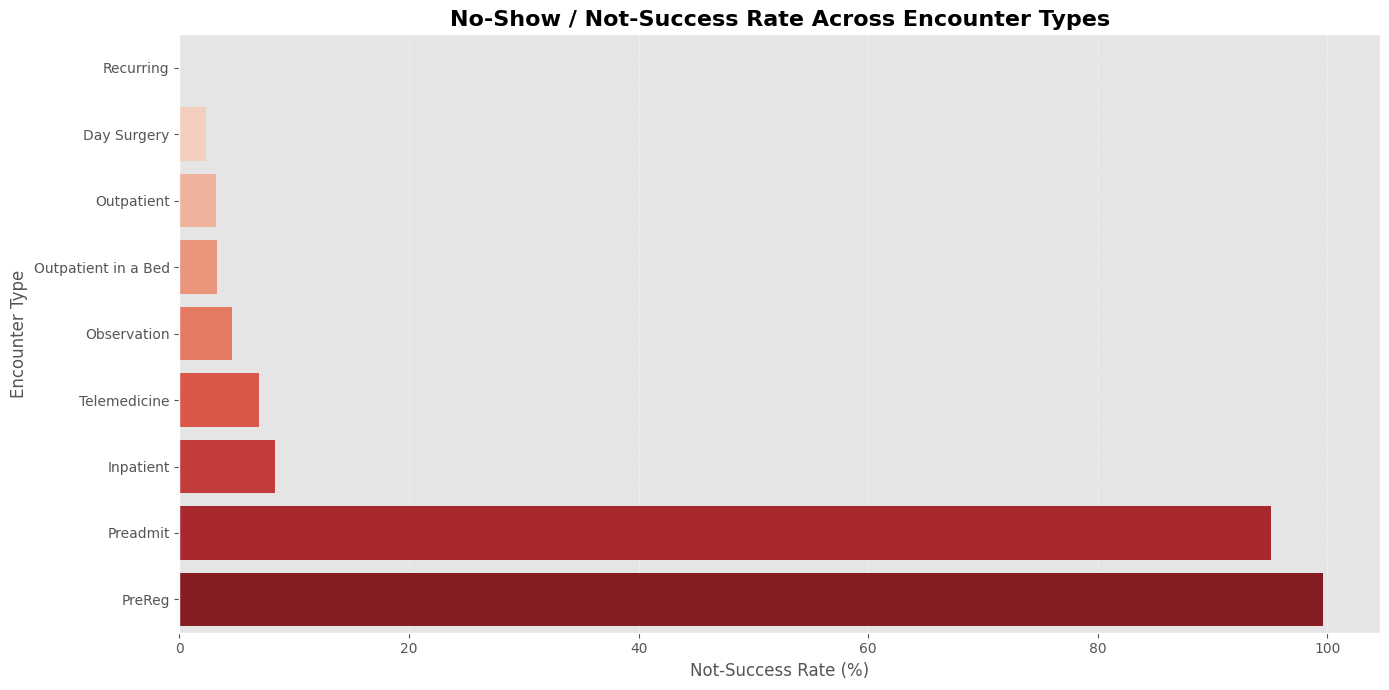

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------
# 1. Compute counts
# ----------------------------------
enc_type_stats = (
    df_full.groupby("ENCNTR_TYPE")["QUALIFYING_FLAG"]
      .agg(
          total_appointments = "count",
          success_count = "sum"        # since 1 = success
      )
)

# ----------------------------------
# 2. Compute NOT_SUCCESS count
# ----------------------------------
enc_type_stats["not_success_count"] = (
    enc_type_stats["total_appointments"] - enc_type_stats["success_count"]
)

# ----------------------------------
# 3. Compute NOT_SUCCESS percentage
# ----------------------------------
enc_type_stats["not_success_rate"] = (
    enc_type_stats["not_success_count"] / enc_type_stats["total_appointments"] * 100
).round(2)

# ----------------------------------
# 4. Sort descending by NOT_SUCCESS rate
# ----------------------------------
enc_type_stats = enc_type_stats.sort_values("not_success_rate", ascending=False)

print("\n📊 NOT_SUCCESS (NoShow + Cancel) Distribution by ENCOUNTER TYPE")
print(enc_type_stats)

# ----------------------------------
# 5. Plot bar chart
# ----------------------------------
plt.figure(figsize=(14, 7))
sns.barplot(
    data=enc_type_stats.reset_index(),
    x="not_success_rate",
    y="ENCNTR_TYPE",
    palette="Reds_r",
    order=enc_type_stats.reset_index()["ENCNTR_TYPE"]
)

plt.title("No-Show / Not-Success Rate Across Encounter Types", fontsize=16, fontweight="bold")
plt.xlabel("Not-Success Rate (%)")
plt.ylabel("Encounter Type")
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Highest NOT_SUCCESS rates appear at the top
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


# ENCNTR_TYPE IS A LEAKAGE VARIABLE - Exclude from Modelling
“Encounter Type introduces target leakage because certain categories (such as Preadmit and PreReg) are only assigned after the appointment outcome is already known, meaning the model would indirectly ‘see’ the result during training and artificially boost performance.”

---
## 4. Data Cleaning and Preprocessing

### 4.1 Handle Negative Lead Time Days

In [11]:
# Check for negative LEAD_TIME_DAYS
print(f"Records with negative LEAD_TIME_DAYS: {(df_full['LEAD_TIME_DAYS'] < 0).sum()}")

# Remove records with negative lead time
df_full = df_full[df_full['LEAD_TIME_DAYS'] >= 0].copy()

print(f"✓ Removed negative LEAD_TIME_DAYS records")
print(f"Updated Dataset Shape: {df_full.shape}")

Records with negative LEAD_TIME_DAYS: 80
✓ Removed negative LEAD_TIME_DAYS records
Updated Dataset Shape: (235728, 26)


### 4.2 Drop Rows with Missing Values

In [12]:
# Columns to check for nulls (exclude the regression targets)
cols_to_check = [col for col in df_full.columns
                 if col not in ['SCH_CANCEL_LEAD_HOURS', 'CANCEL_TO_APPT_LEAD_HOURS']]

print("\n📊 Missing Values Before Dropping:")
print(df_full[cols_to_check].isnull().sum()[df_full[cols_to_check].isnull().sum() > 0])

# Drop rows with any missing values in these columns
rows_before = len(df_full)
df_full = df_full.dropna(subset=cols_to_check).copy()
rows_after = len(df_full)

print(f"\n✓ Dropped {rows_before - rows_after} rows with missing values")
print(f"Updated Dataset Shape: {df_full.shape}")
print(f"\n📊 Remaining Missing Values:")
print(df_full[cols_to_check].isnull().sum().sum())


📊 Missing Values Before Dropping:
SEX                      50
LANGUAGE                 76
ZIPCODE3                162
APPT_TYPE_CODE         4069
ENCNTR_TYPE            1099
NURSE_UNIT_CODE           8
ATTENDING_PHYSICIAN      34
REFERRING_PHYSICIAN     405
PRIMARY_PLAN_TYPE        51
dtype: int64

✓ Dropped 5303 rows with missing values
Updated Dataset Shape: (230425, 26)

📊 Remaining Missing Values:
0


In [13]:
unique_age_values = df_full['AGE'].unique()
unique_age_values

array(['57', '55', '19', '74', '75', '76', '60', '62', '65', '66', '47',
       '70', '52', '39', '71', '56', '58', '51', '53', '54', '40', '83',
       '80', '67', '29', '68', '44', '64', '81', '82', '50', '48', '84',
       '35', '36', '72', '73', '79', '78', '32', '33', '90+', '69', '30',
       '31', '61', '85', '86', '77', '42', '87', '37', '34', '63', '43',
       '59', '49', '45', '46', '89', '88', '41', '14', '15', '17', '28',
       '38', '26', '25', '18', '23', '24', '22', '16', '27', '20', '21',
       '13', '11', '12', '10', '9', '8', '7', '3', '5', '2', '4', '1',
       '6'], dtype=object)

In [14]:
# Get the unique AGE values as strings
unique_vals = df_full['AGE'].astype(str).unique()

# Define the encoding logic:
# If "90" already exists in data → treat "90+" as 95
# If "90" not present → treat "90+" as 90
encode_90_plus_as = 95 if '90' in unique_vals else 90

# Create a cleaned AGE column
df_full['AGE'] = (
    df_full['AGE']
      .astype(str)
      .str.strip()
      .replace({'90+': encode_90_plus_as})
)

# Convert to numeric safely
df_full['AGE'] = pd.to_numeric(df_full['AGE'], errors='coerce')

### 4.3 Create Target Variable for Binary Classification

In [15]:
print("\n🎯 Creating binary target: SUCCESS vs NOT_SUCCESS (CANCELED + NOSHOW)")
print("="*80)

# Create BINARY classification target based on APPT_STATUS
# Class 1: CANCELED or NOSHOW (combined)
# Class 0: SUCCESS

def create_binary_target(status):
    if pd.isna(status):
        return 'Unknown'
    status_upper = str(status).upper()
    if 'NOSHOW' in status_upper or 'NO SHOW' in status_upper or 'CANCEL' in status_upper:
        return 'NOT_SUCCESS'  # Class 1: CANCELED or NOSHOW
    else:
        return 'SUCCESS'      # Class 0: SUCCESS

df_full['TARGET_CLASS'] = df_full['APPT_STATUS'].apply(create_binary_target)

# Encode target to numeric (0, 1) for model compatibility
# 0 = SUCCESS, 1 = NOT_SUCCESS (CANCELED or NOSHOW)
target_mapping = {'SUCCESS': 0, 'NOT_SUCCESS': 1}
df_full['TARGET_ENCODED'] = df_full['TARGET_CLASS'].map(target_mapping)

# Also keep original status for any follow-up analysis
def get_original_status(status):
    if pd.isna(status):
        return 'Unknown'
    status_upper = str(status).upper()
    if 'NOSHOW' in status_upper or 'NO SHOW' in status_upper:
        return 'NOSHOW'
    elif 'CANCEL' in status_upper:
        return 'CANCELED'
    else:
        return 'SUCCESS'

df_full['ORIGINAL_STATUS'] = df_full['APPT_STATUS'].apply(get_original_status)

print("\n📋 Binary Target Distribution (TARGET_CLASS):")
print(df_full['TARGET_CLASS'].value_counts())

print("\n📊 Encoded Target Distribution (TARGET_ENCODED):")
print(df_full['TARGET_ENCODED'].value_counts().sort_index())
print("\nMapping: 0=SUCCESS, 1=NOT_SUCCESS (CANCELED or NOSHOW)")

print("\n📋 Original Status Distribution (ORIGINAL_STATUS):")
print(df_full['ORIGINAL_STATUS'].value_counts())

print("\n🔍 Cross-validation with QUALIFYING_FLAG:")
print(pd.crosstab(df_full['TARGET_CLASS'], df_full['QUALIFYING_FLAG'], margins=True))

print("\n✅ Binary target creation complete!")


🎯 Creating binary target: SUCCESS vs NOT_SUCCESS (CANCELED + NOSHOW)

📋 Binary Target Distribution (TARGET_CLASS):
TARGET_CLASS
SUCCESS        181841
NOT_SUCCESS     48584
Name: count, dtype: int64

📊 Encoded Target Distribution (TARGET_ENCODED):
TARGET_ENCODED
0    181841
1     48584
Name: count, dtype: int64

Mapping: 0=SUCCESS, 1=NOT_SUCCESS (CANCELED or NOSHOW)

📋 Original Status Distribution (ORIGINAL_STATUS):
ORIGINAL_STATUS
SUCCESS     181841
CANCELED     40482
NOSHOW        8102
Name: count, dtype: int64

🔍 Cross-validation with QUALIFYING_FLAG:
QUALIFYING_FLAG      0       1     All
TARGET_CLASS                          
NOT_SUCCESS      48584       0   48584
SUCCESS              0  181841  181841
All              48584  181841  230425

✅ Binary target creation complete!


### 4.4 Feature Engineering

In [16]:
# Create new features
print("🔧 Creating engineered features...\n")

# ---- Ensure numeric types where needed ----
numeric_cols = ['AGE', 'LEAD_TIME_DAYS', 'APPT_HOUR', 'DURATION']
for col in numeric_cols:
    if col in df_full.columns:
        df_full[col] = pd.to_numeric(df_full[col], errors='coerce')

# If APPT_DOW is stored as string, convert to numeric too
if 'APPT_DOW' in df_full.columns:
    df_full['APPT_DOW'] = pd.to_numeric(df_full['APPT_DOW'], errors='coerce')

# Weekend flag
df_full['IS_WEEKEND'] = df_full['APPT_DOW'].isin([0, 6]).astype(int)  # Sunday=0, Saturday=6

# Previous appointment count (by patient)
df_full['APPT_COUNT_BY_PATIENT'] = df_full.groupby('UNIQUE_ID')['APPT'].transform('count')

print("✓ Created the following features:")
print("  - IS_WEEKEND")
print("  - APPT_COUNT_BY_PATIENT")

print(f"\nUpdated Dataset Shape: {df_full.shape}")

🔧 Creating engineered features...

✓ Created the following features:
  - IS_WEEKEND
  - APPT_COUNT_BY_PATIENT

Updated Dataset Shape: (230425, 31)


---
## 5. Train/Test (Patient-Level)

In [17]:
print("\n🧬 Performing patient-level train/test split...")
print("="*80)

# Get unique patient IDs
unique_patients = df_full['UNIQUE_ID'].unique()
print(f"Total Unique Patients: {len(unique_patients):,}\n")

# Example: 75% Train, 25% Test at patient level
patients_train, patients_test = train_test_split(
    unique_patients,
    test_size=0.25,
    random_state=RANDOM_STATE
)

# Create dataframe splits (no patient overlap)
df_train = df_full[df_full['UNIQUE_ID'].isin(patients_train)].copy()
df_test  = df_full[df_full['UNIQUE_ID'].isin(patients_test)].copy()

print("📊 PATIENT-LEVEL SPLIT:")
print("="*60)
print(f"Train Patients: {len(patients_train):,} ({len(patients_train)/len(unique_patients)*100:.1f}%)")
print(f"Test Patients:  {len(patients_test):,} ({len(patients_test)/len(unique_patients)*100:.1f}%)")

print("\n📊 RECORD-LEVEL SPLIT:")
print("="*60)
print(f"Train Records: {len(df_train):,} ({len(df_train)/len(df_full)*100:.1f}%)")
print(f"Test Records:  {len(df_test):,} ({len(df_test)/len(df_full)*100:.1f}%)")
print("="*60)

# Verify no patient overlap
assert len(set(patients_train) & set(patients_test)) == 0, "Overlap between train and test!"
print("\n✓ No patient overlap between splits confirmed!")



🧬 Performing patient-level train/test split...
Total Unique Patients: 58,113

📊 PATIENT-LEVEL SPLIT:
Train Patients: 43,584 (75.0%)
Test Patients:  14,529 (25.0%)

📊 RECORD-LEVEL SPLIT:
Train Records: 172,732 (75.0%)
Test Records:  57,693 (25.0%)

✓ No patient overlap between splits confirmed!


---
## 6. Prepare Data for Classification

### 6.1 Remove Target Leakage Features - SELECT INDEPENDENT VARIABLES

In [18]:
# Features to exclude from classification (target leakage)
exclude_features = [
    'SCH_CANCEL_LEAD_HOURS',      # Won't have for new appointments while booking
    'CANCEL_TO_APPT_LEAD_HOURS',  # Won't have for new appointments while booking
    'APPT_STATUS',                 # This is used to create target
    'QUALIFYING_FLAG',             # This is related to target
    'TARGET_CLASS',                # This is our target (string)
    'TARGET_ENCODED',              # This is our target (numeric)
    'UNIQUE_ID',                   # ID field
    'ENCNTR',                      # ID field
    'APPT',                       # Appointment Identifier
    'DURATION',                   # Won't know while booking (Inaccurate)
    'ORIGINAL_STATUS', 'ENCNTR_TYPE' # Leakage
]

print("🚫 Excluded features for classification:")
for feat in exclude_features:
    print(f"  - {feat}")

🚫 Excluded features for classification:
  - SCH_CANCEL_LEAD_HOURS
  - CANCEL_TO_APPT_LEAD_HOURS
  - APPT_STATUS
  - QUALIFYING_FLAG
  - TARGET_CLASS
  - TARGET_ENCODED
  - UNIQUE_ID
  - ENCNTR
  - APPT
  - DURATION
  - ORIGINAL_STATUS
  - ENCNTR_TYPE


### 6.2 Encode Categorical Variables

In [19]:
# Get feature columns
feature_cols = [col for col in df_full.columns if col not in exclude_features]

# Separate categorical and numerical
cat_features = df_train[feature_cols].select_dtypes(include=['object', 'category']).columns.tolist()
num_features = df_train[feature_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\n📊 Feature Summary:")
print(f"Categorical Features: {len(cat_features)}")
print(f"Numerical Features: {len(num_features)}")
print(f"Total Features: {len(feature_cols)}")

# Label encode categorical features
label_encoders = {}

for col in cat_features:
    le = LabelEncoder()

    # Fit on all unique values from BOTH train and test
    all_values = pd.concat([df_train[col], df_test[col]]).astype(str).unique()
    le.fit(all_values)

    # Transform each split
    df_train[col] = le.transform(df_train[col].astype(str))
    df_test[col] = le.transform(df_test[col].astype(str))

    label_encoders[col] = le

print("\n✓ Categorical features encoded successfully!")


📊 Feature Summary:
Categorical Features: 9
Numerical Features: 10
Total Features: 19

✓ Categorical features encoded successfully!


In [20]:
num_features

['AGE',
 'LEAD_TIME_DAYS',
 'APPT_DOW',
 'APPT_HOUR',
 'APPT_TYPE_CODE',
 'MEDICAL_SERVICE_CODE',
 'FACILITY_CODE',
 'NURSE_UNIT_CODE',
 'IS_WEEKEND',
 'APPT_COUNT_BY_PATIENT']

In [21]:
cat_features

['SEX',
 'LANGUAGE',
 'ZIPCODE3',
 'TIME_OF_DAY_BUCKET',
 'SEASON_BUCKET',
 'SERVICE_LINE_USED',
 'ATTENDING_PHYSICIAN',
 'REFERRING_PHYSICIAN',
 'PRIMARY_PLAN_TYPE']

In [22]:
print("\n" + "="*80)
print("📋 LABEL ENCODING MAPPING (SELECTED VARIABLE ONLY)")
print("="*80)

# List of categorical variables (comment/uncomment to switch)
#cat_to_inspect = 'SEX'
#cat_to_inspect = 'LANGUAGE'
#cat_to_inspect = 'ZIPCODE3'
#cat_to_inspect = 'TIME_OF_DAY_BUCKET'
#cat_to_inspect = 'SEASON_BUCKET'
#cat_to_inspect = 'SERVICE_LINE_USED'
#cat_to_inspect = 'ATTENDING_PHYSICIAN'
#cat_to_inspect = 'REFERRING_PHYSICIAN'
#cat_to_inspect = 'PRIMARY_PLAN_TYPE'

# 👉 Choose ONE variable to print
cat_to_inspect = 'SEX'   # <-- modify this line only

# Validate variable is encoded
if cat_to_inspect not in label_encoders:
    raise ValueError(f"'{cat_to_inspect}' is not in label_encoders!")

# Print encoding mapping
le = label_encoders[cat_to_inspect]

print(f"\n🔎 {cat_to_inspect}:")
print("-" * 60)
for i, cls in enumerate(le.classes_):
    print(f"  {cls!r:40s} -> {i}")
print(f"  Total unique values: {len(le.classes_)}")

print("\n" + "="*80)
print(f"✓ Encoding inspected for: {cat_to_inspect}")
print("="*80)


📋 LABEL ENCODING MAPPING (SELECTED VARIABLE ONLY)

🔎 SEX:
------------------------------------------------------------
  'Female'                                 -> 0
  'Male'                                   -> 1
  'Nonbinary'                              -> 2
  'Unknown'                                -> 3
  Total unique values: 4

✓ Encoding inspected for: SEX


### 6.3 Prepare X and y for Classification

In [23]:
print("\n🧱 Preparing feature matrices and target vectors...")
print("="*80)

# Get feature columns (exclude ID/target/etc.)
feature_cols = [col for col in df_full.columns if col not in exclude_features]

# Prepare features
X_train = df_train[feature_cols]
X_test  = df_test[feature_cols]

# Encoded binary targets (0=SUCCESS, 1=NOT_SUCCESS)
y_train = df_train['TARGET_ENCODED']
y_test  = df_test['TARGET_ENCODED']

# Also keep string versions for reference / reporting
y_train_str = df_train['TARGET_CLASS']
y_test_str  = df_test['TARGET_CLASS']

print("\n📊 Classification Data Shape:")
print("="*60)
print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")

print("\n📊 Target Distribution (Encoded):")
print("="*60)
print("Train:")
print(y_train.value_counts().sort_index())
print("\nTest:")
print(y_test.value_counts().sort_index())

print("\nMapping: 0=SUCCESS, 1=NOT_SUCCESS (CANCELED or NOSHOW)")
print("\n✅ Features and targets are ready for modeling!")



🧱 Preparing feature matrices and target vectors...

📊 Classification Data Shape:
X_train: (172732, 19)
X_test:  (57693, 19)

📊 Target Distribution (Encoded):
Train:
TARGET_ENCODED
0    136157
1     36575
Name: count, dtype: int64

Test:
TARGET_ENCODED
0    45684
1    12009
Name: count, dtype: int64

Mapping: 0=SUCCESS, 1=NOT_SUCCESS (CANCELED or NOSHOW)

✅ Features and targets are ready for modeling!


In [24]:
X_train.columns

Index(['AGE', 'SEX', 'LANGUAGE', 'ZIPCODE3', 'LEAD_TIME_DAYS', 'APPT_DOW',
       'APPT_HOUR', 'TIME_OF_DAY_BUCKET', 'SEASON_BUCKET', 'APPT_TYPE_CODE',
       'MEDICAL_SERVICE_CODE', 'SERVICE_LINE_USED', 'FACILITY_CODE',
       'NURSE_UNIT_CODE', 'ATTENDING_PHYSICIAN', 'REFERRING_PHYSICIAN',
       'PRIMARY_PLAN_TYPE', 'IS_WEEKEND', 'APPT_COUNT_BY_PATIENT'],
      dtype='object')

---
## 7. Classification Models

### 7.1 Train Classification Models

In [25]:
classification_models = {}
classification_results = {}

# Target class names for reference
class_names = ['SUCCESS', 'NOT_SUCCESS']  # 0, 1

print("\n🚀 Training Binary Classification Models...\n")
print("="*80)
print("Binary Classification: SUCCESS (0) vs NOT_SUCCESS (1)")
print("NOT_SUCCESS includes: CANCELED + NOSHOW")
print("="*80)

# 1. Random Forest
print("\n1️⃣ Training Random Forest...")
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight='balanced'
)
rf_clf.fit(X_train, y_train)
classification_models['Random Forest'] = rf_clf
print("   ✓ Random Forest trained")

# 2. XGBoost
print("\n2️⃣ Training XGBoost...")
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='logloss'  # Binary classification metric
)
xgb_clf.fit(X_train, y_train)
classification_models['XGBoost'] = xgb_clf
print("   ✓ XGBoost trained")

# 3. LightGBM
print("\n3️⃣ Training LightGBM...")
lgbm_clf = LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight='balanced',
    verbose=-1
)
lgbm_clf.fit(X_train, y_train)
classification_models['LightGBM'] = lgbm_clf
print("   ✓ LightGBM trained")

# 4. CatBoost
print("\n4️⃣ Training CatBoost...")
catboost_clf = CatBoostClassifier(
    iterations=200,
    depth=8,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    verbose=0,
    auto_class_weights='Balanced'
)
catboost_clf.fit(X_train, y_train)
classification_models['CatBoost'] = catboost_clf
print("   ✓ CatBoost trained")

print("\n" + "="*80)
print("✓ All binary classification models trained successfully!")


🚀 Training Binary Classification Models...

Binary Classification: SUCCESS (0) vs NOT_SUCCESS (1)
NOT_SUCCESS includes: CANCELED + NOSHOW

1️⃣ Training Random Forest...
   ✓ Random Forest trained

2️⃣ Training XGBoost...
   ✓ XGBoost trained

3️⃣ Training LightGBM...
   ✓ LightGBM trained

4️⃣ Training CatBoost...
   ✓ CatBoost trained

✓ All binary classification models trained successfully!


### 7.2 Evaluate Classification Models

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

POS_LABEL = 1  # NOT_SUCCESS

def evaluate_classifier(model, X, y, model_name, dataset_name):
    # Predictions (0/1)
    y_pred = model.predict(X)

    # Predicted probabilities (if available)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X)
    else:
        y_pred_proba = None

    # Binary metrics: positive class = 1 (NOT_SUCCESS)
    accuracy  = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, pos_label=POS_LABEL, zero_division=0)
    recall    = recall_score(y, y_pred, pos_label=POS_LABEL, zero_division=0)
    f1        = f1_score(y, y_pred, pos_label=POS_LABEL, zero_division=0)

    # ROC-AUC (binary, probability of NOT_SUCCESS)
    roc_auc = None
    try:
        if y_pred_proba is not None and y_pred_proba.shape[1] == 2:
            classes = list(model.classes_)
            pos_idx = classes.index(POS_LABEL)  # index of class 1
            roc_auc = roc_auc_score(y, y_pred_proba[:, pos_idx])
    except ValueError as e:
        print(f"[WARN] Could not compute ROC-AUC for {model_name} on {dataset_name}: {e}")
        roc_auc = None

    results = {
        'Model': model_name,
        'Dataset': dataset_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'ROC_AUC': roc_auc
    }

    return results, y_pred, y_pred_proba

# Evaluate all models
print("\n📏 Evaluating all models on Train and Test (binary, NOT_SUCCESS as positive)...")
print("="*100)

all_results = []

for model_name, model in classification_models.items():
    # Train set
    train_results, train_pred, train_proba = evaluate_classifier(
        model, X_train, y_train, model_name, 'Train'
    )
    all_results.append(train_results)

    # Test set
    test_results, test_pred, test_proba = evaluate_classifier(
        model, X_test, y_test, model_name, 'Test'
    )
    all_results.append(test_results)

    # Store predictions and probabilities
    classification_results[model_name] = {
        'train_pred': train_pred,
        'train_proba': train_proba,
        'test_pred': test_pred,
        'test_proba': test_proba
    }

# Create results dataframe
results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)

print("\n📊 CLASSIFICATION MODELS PERFORMANCE (BINARY: NOT_SUCCESS=1):")
print("="*100)
print(results_df.to_string(index=False))



📏 Evaluating all models on Train and Test (binary, NOT_SUCCESS as positive)...

📊 CLASSIFICATION MODELS PERFORMANCE (BINARY: NOT_SUCCESS=1):
        Model Dataset  Accuracy  Precision  Recall  F1_Score  ROC_AUC
Random Forest   Train    0.7478     0.4367  0.6579    0.5249   0.8035
Random Forest    Test    0.6993     0.3535  0.5365    0.4262   0.6992
      XGBoost   Train    0.8253     0.8486  0.2130    0.3405   0.8124
      XGBoost    Test    0.8047     0.6415  0.1402    0.2301   0.7094
     LightGBM   Train    0.6880     0.3660  0.6469    0.4675   0.7428
     LightGBM    Test    0.6713     0.3391  0.6102    0.4359   0.7076
     CatBoost   Train    0.6855     0.3642  0.6512    0.4672   0.7428
     CatBoost    Test    0.6704     0.3393  0.6160    0.4376   0.7090


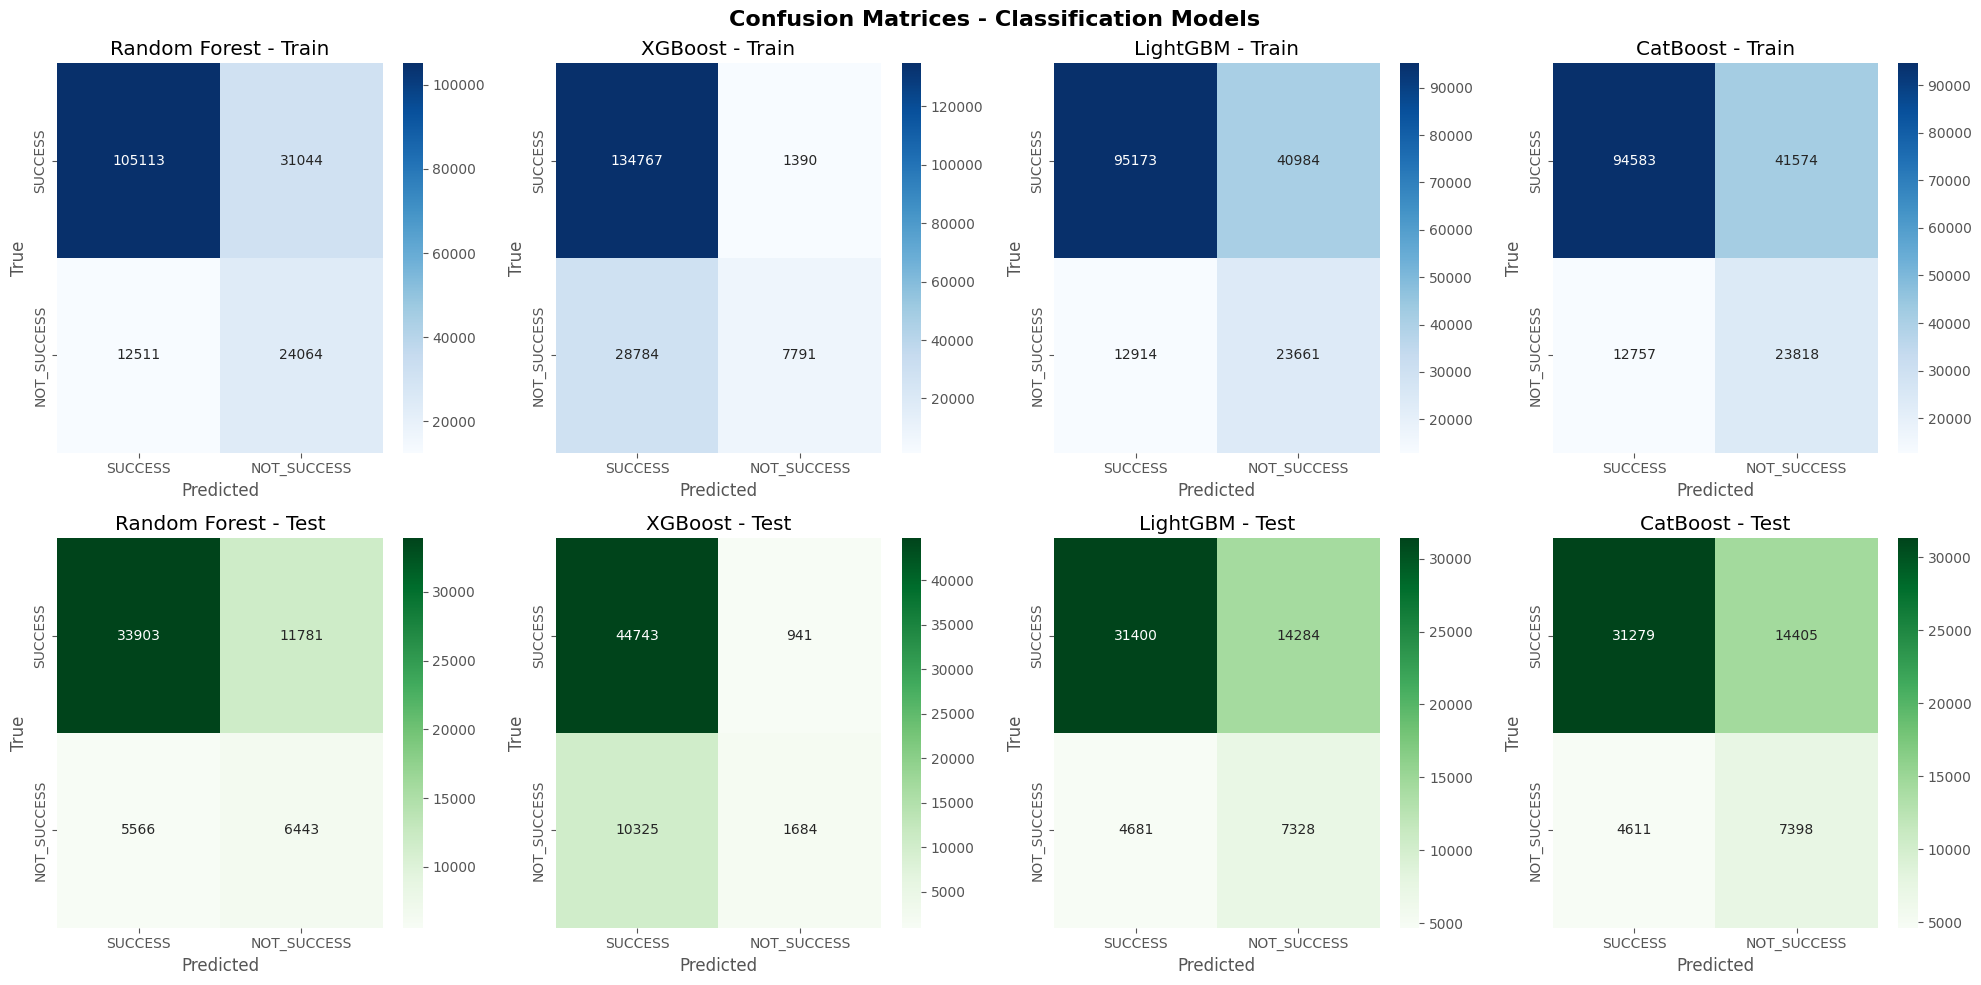

In [27]:
# Confusion Matrices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Confusion Matrices - Classification Models', fontsize=16, fontweight='bold')

idx = 0
for model_name, model in classification_models.items():
    # Train
    y_pred_train = classification_results[model_name]['train_pred']
    cm_train = confusion_matrix(y_train, y_pred_train)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0, idx],
                xticklabels=class_names, yticklabels=class_names)
    axes[0, idx].set_title(f'{model_name} - Train')
    axes[0, idx].set_ylabel('True')
    axes[0, idx].set_xlabel('Predicted')

    # Test
    y_pred_test = classification_results[model_name]['test_pred']
    cm_test = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1, idx],
                xticklabels=class_names, yticklabels=class_names)
    axes[1, idx].set_title(f'{model_name} - Test')
    axes[1, idx].set_ylabel('True')
    axes[1, idx].set_xlabel('Predicted')

    idx += 1

plt.tight_layout()
plt.show()


🌲 Extracting feature importances from tree-based models...
Total features available: 19

📊 Computing importances for:
   - Random Forest
   - XGBoost
   - LightGBM
   - CatBoost

✓ Feature importance extraction complete!

📈 Plotting top features for each model...


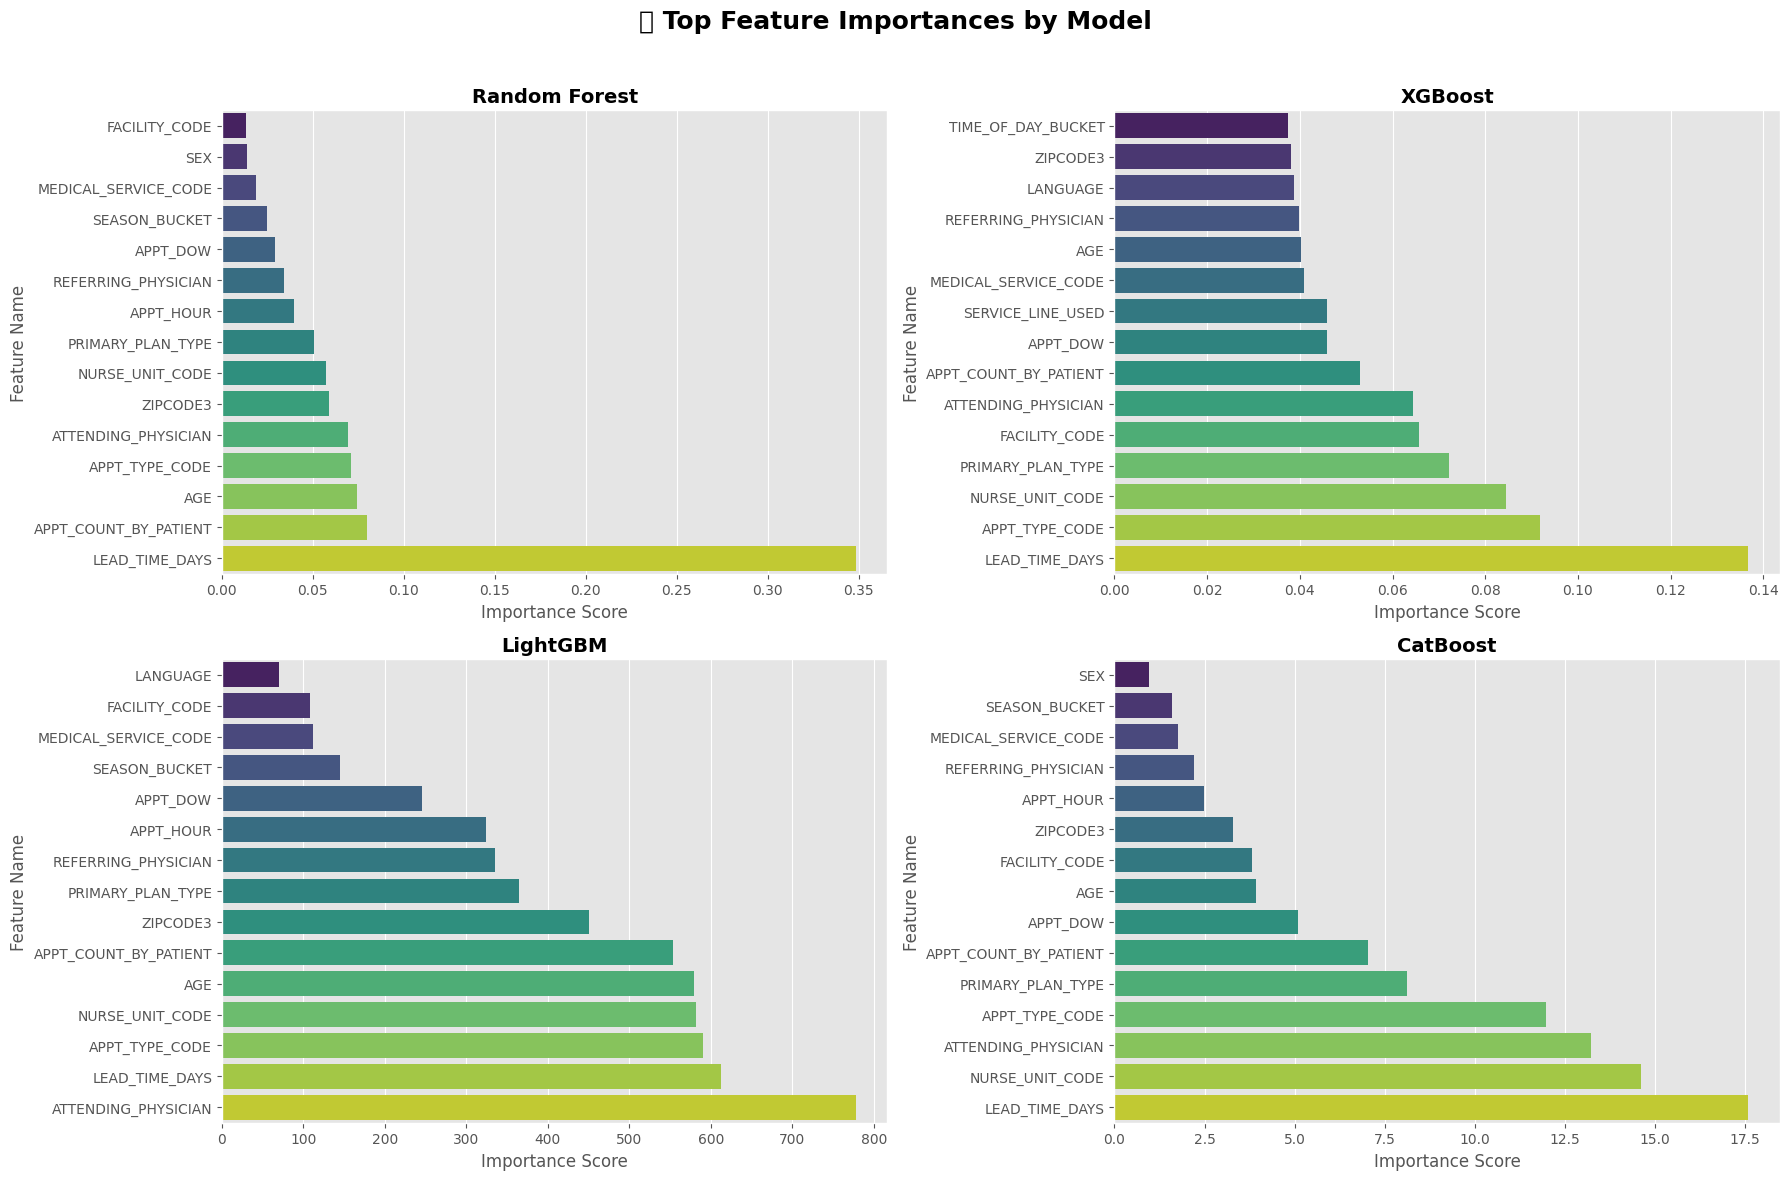


✓ Feature importance plots generated!


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n🌲 Extracting feature importances from tree-based models...")
print("="*100)

# ==============================
# 1. Helper: Extract importances
# ==============================
def get_feature_importances(model, model_name, feature_names):
    """
    Returns a DataFrame with columns: ['Feature', 'Importance']
    for the given model.
    """

    # Many models expose .feature_importances_
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_

    # CatBoost uses get_feature_importance()
    elif model_name.lower() == "catboost":
        importances = model.get_feature_importance()

    else:
        raise ValueError(f"Model {model_name} does not expose feature importances.")

    # Create DF
    fi_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    })

    # Sort descending
    fi_df = fi_df.sort_values("Importance", ascending=False).reset_index(drop=True)

    return fi_df


# ==============================
# 2. Feature names (from X_train)
# ==============================
feature_names = X_train.columns
print(f"Total features available: {len(feature_names)}")


# ==============================
# 3. Compute feature importances
# ==============================
feature_importance_dict = {}

print("\n📊 Computing importances for:")
for model_name, model in classification_models.items():
    print(f"   - {model_name}")
    fi_df = get_feature_importances(model, model_name, feature_names)
    feature_importance_dict[model_name] = fi_df

print("\n✓ Feature importance extraction complete!")


# ==============================
# 4. Plot top N features
# ==============================
TOP_N = 15  # Customize this if needed

model_names_order = ["Random Forest", "XGBoost", "LightGBM", "CatBoost"]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("🔥 Top Feature Importances by Model", fontsize=18, fontweight='bold')

print("\n📈 Plotting top features for each model...")

for ax, model_name in zip(axes.flatten(), model_names_order):
    fi_df = feature_importance_dict[model_name].head(TOP_N).iloc[::-1]  # reverse for nice barh plot

    sns.barplot(
        data=fi_df,
        x="Importance",
        y="Feature",
        ax=ax,
        palette="viridis"
    )
    ax.set_title(model_name, fontsize=14, fontweight='bold')
    ax.set_xlabel("Importance Score", fontsize=12)
    ax.set_ylabel("Feature Name", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\n✓ Feature importance plots generated!")


In [30]:
# =============================================================
# 📋 CELL: DETAILED CLASSIFICATION REPORTS (BINARY: 0/1)
# =============================================================

print("\n📋 DETAILED CLASSIFICATION REPORTS")
print("="*100)
print("🔎 Reporting metrics for: SUCCESS (0) vs NOT_SUCCESS (1)")
print("="*100)

for model_name, model in classification_models.items():
    print(f"\n{'='*100}")
    print(f"🧠 MODEL: {model_name}")
    print(f"{'='*100}")

    print("\n📊 TEST SET CLASSIFICATION REPORT:")
    print("-"*100)

    y_pred_test = classification_results[model_name]['test_pred']

    # Ensure strictly binary
    assert set(y_test.unique()) <= {0, 1}, "ERROR: y_test must be binary for classification_report."

    # Produce binary report
    print(classification_report(
        y_test,
        y_pred_test,
        target_names=['SUCCESS', 'NOT_SUCCESS'],
        zero_division=0
    ))



📋 DETAILED CLASSIFICATION REPORTS
🔎 Reporting metrics for: SUCCESS (0) vs NOT_SUCCESS (1)

🧠 MODEL: Random Forest

📊 TEST SET CLASSIFICATION REPORT:
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

     SUCCESS       0.86      0.74      0.80     45684
 NOT_SUCCESS       0.35      0.54      0.43     12009

    accuracy                           0.70     57693
   macro avg       0.61      0.64      0.61     57693
weighted avg       0.75      0.70      0.72     57693


🧠 MODEL: XGBoost

📊 TEST SET CLASSIFICATION REPORT:
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

     SUCCESS       0.81      0.98      0.89     45684
 NOT_SUCCESS       0.64      0.14      0.23     12009

    accuracy                           0.80     57693
   macro avg       0.73      0.56      0.56     57

### 7.3 Threshold Optimization (Binary Classification)

In [31]:
print("\n📊 THRESHOLD OPTIMIZATION FOR BINARY CLASSIFICATION")
print("="*80)
print("Detecting: NOT_SUCCESS (CANCELED + NOSHOW) vs SUCCESS")
print("Positive class = 1 (NOT_SUCCESS)")
print("="*80)

# Select best model for threshold analysis (change if needed)
threshold_model_name = 'XGBoost'
threshold_model = classification_models[threshold_model_name]

print(f"\n🔎 Using model for threshold analysis: {threshold_model_name}")

# Get predicted probabilities for NOT_SUCCESS on the test set
if not hasattr(threshold_model, "predict_proba"):
    raise ValueError(f"Model {threshold_model_name} does not support predict_proba!")

y_test_proba = threshold_model.predict_proba(X_test)

# Ensure we use the correct column for class 1 (NOT_SUCCESS)
classes = list(threshold_model.classes_)
pos_idx = classes.index(1)  # class 1 = NOT_SUCCESS
prob_not_success = y_test_proba[:, pos_idx]

# Sanity check: y_test must be binary 0/1
assert set(y_test.unique()) <= {0, 1}, "y_test must be binary (0/1) for threshold analysis."

# Test thresholds from 0 to 1 in steps of 0.05
thresholds = np.arange(0.0, 1.05, 0.05)
threshold_results = []

for threshold in thresholds:
    # Predict NOT_SUCCESS if probability >= threshold
    y_pred_threshold = (prob_not_success >= threshold).astype(int)

    accuracy  = accuracy_score(y_test, y_pred_threshold)
    precision = precision_score(y_test, y_pred_threshold, pos_label=1, zero_division=0)
    recall    = recall_score(y_test, y_pred_threshold, pos_label=1, zero_division=0)
    f1        = f1_score(y_test, y_pred_threshold, pos_label=1, zero_division=0)

    threshold_results.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    })

threshold_df = pd.DataFrame(threshold_results)

print("\nThreshold Analysis Results:")
print(threshold_df.to_string(index=False))

print("\n📌 OPTIMAL THRESHOLDS (BASED ON TEST SET):")
print("="*60)

opt_f1_idx        = threshold_df['F1_Score'].idxmax()
opt_precision_idx = threshold_df['Precision'].idxmax()
opt_recall_idx    = threshold_df['Recall'].idxmax()

print(f"Best F1-Score: {threshold_df.loc[opt_f1_idx, 'F1_Score']:.4f} at threshold {threshold_df.loc[opt_f1_idx, 'Threshold']:.2f}")
print(f"Best Precision: {threshold_df.loc[opt_precision_idx, 'Precision']:.4f} at threshold {threshold_df.loc[opt_precision_idx, 'Threshold']:.2f}")
print(f"Best Recall: {threshold_df.loc[opt_recall_idx, 'Recall']:.4f} at threshold {threshold_df.loc[opt_recall_idx, 'Threshold']:.2f}")

# Save threshold analysis
threshold_df.to_csv('threshold_analysis.csv', index=False)
print("\n✓ Threshold analysis saved to: threshold_analysis.csv")
print("   🔁 Use the chosen threshold in production to convert probabilities into NOT_SUCCESS flags.")



📊 THRESHOLD OPTIMIZATION FOR BINARY CLASSIFICATION
Detecting: NOT_SUCCESS (CANCELED + NOSHOW) vs SUCCESS
Positive class = 1 (NOT_SUCCESS)

🔎 Using model for threshold analysis: XGBoost

Threshold Analysis Results:
 Threshold  Accuracy  Precision   Recall  F1_Score
      0.00  0.208154   0.208154 1.000000  0.344581
      0.05  0.250152   0.216201 0.991257  0.354978
      0.10  0.369161   0.239844 0.936048  0.381847
      0.15  0.522888   0.277547 0.806062  0.412916
      0.20  0.646647   0.325501 0.650595  0.433911
      0.25  0.725131   0.380458 0.510034  0.435819
      0.30  0.766072   0.431291 0.388625  0.408848
      0.35  0.787271   0.481997 0.294279  0.365441
      0.40  0.797705   0.533189 0.226080  0.317525
      0.45  0.802090   0.581472 0.175618  0.269762
      0.50  0.804725   0.641524 0.140228  0.230149
      0.55  0.804014   0.686108 0.107753  0.186254
      0.60  0.803286   0.730447 0.087101  0.155643
      0.65  0.802281   0.773636 0.070864  0.129834
      0.70  0.801206

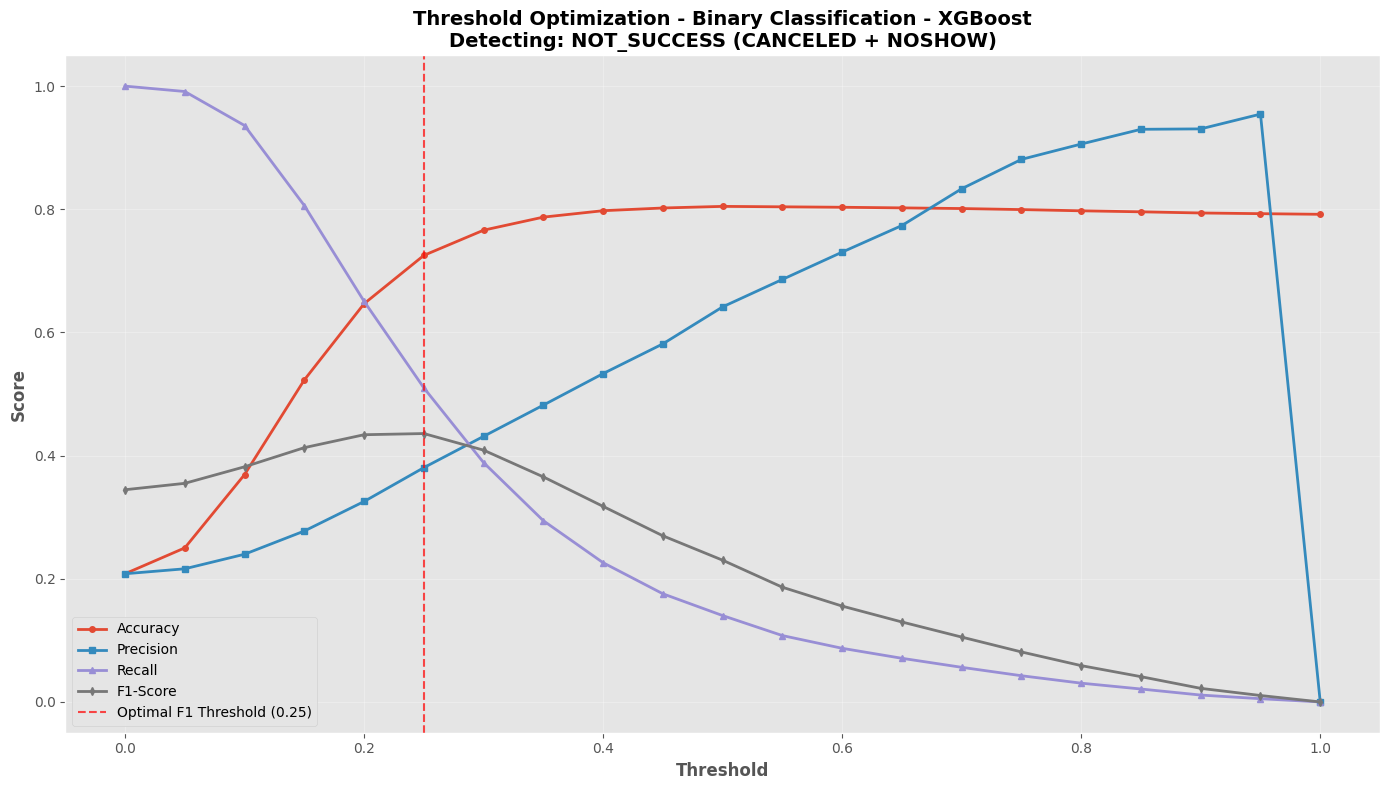


💡 THRESHOLD SELECTION GUIDE:
• High Precision threshold: Use when false positives are costly
  (e.g., sending unnecessary reminders to patients)
• High Recall threshold: Use when false negatives are costly
  (e.g., missing actual cancellations/no-shows)
• Balanced F1 threshold: Best overall trade-off

✓ You can adjust the threshold based on business requirements!


In [32]:
import matplotlib.pyplot as plt  # make sure this is at the top of your notebook

# Plot threshold analysis
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(
    threshold_df['Threshold'],
    threshold_df['Accuracy'],
    marker='o',
    label='Accuracy',
    linewidth=2,
    markersize=4
)
ax.plot(
    threshold_df['Threshold'],
    threshold_df['Precision'],
    marker='s',
    label='Precision',
    linewidth=2,
    markersize=4
)
ax.plot(
    threshold_df['Threshold'],
    threshold_df['Recall'],
    marker='^',
    label='Recall',
    linewidth=2,
    markersize=4
)
ax.plot(
    threshold_df['Threshold'],
    threshold_df['F1_Score'],
    marker='d',
    label='F1-Score',
    linewidth=2,
    markersize=4
)

# Mark optimal F1 threshold
opt_threshold = threshold_df.loc[opt_f1_idx, 'Threshold']
ax.axvline(
    x=opt_threshold,
    color='red',
    linestyle='--',
    alpha=0.7,
    label=f'Optimal F1 Threshold ({opt_threshold:.2f})'
)

ax.set_xlabel('Threshold', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title(
    f'Threshold Optimization - Binary Classification - {threshold_model_name}\n'
    'Detecting: NOT_SUCCESS (CANCELED + NOSHOW)',
    fontsize=14,
    fontweight='bold'
)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\n💡 THRESHOLD SELECTION GUIDE:")
print("="*60)
print("• High Precision threshold: Use when false positives are costly")
print("  (e.g., sending unnecessary reminders to patients)")
print("• High Recall threshold: Use when false negatives are costly")
print("  (e.g., missing actual cancellations/no-shows)")
print("• Balanced F1 threshold: Best overall trade-off")
print("\n✓ You can adjust the threshold based on business requirements!")


📊 Analyzing predicted probabilities for NOT_SUCCESS (XGBoost)...


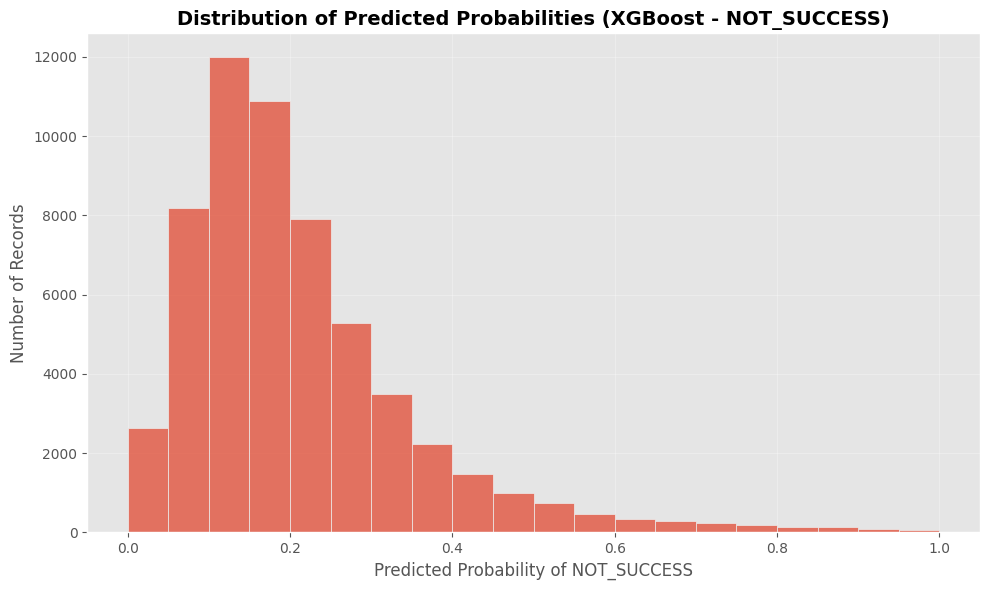

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n📊 Analyzing predicted probabilities for NOT_SUCCESS (XGBoost)...")
print("="*80)

# 1. Get predicted probabilities for NOT_SUCCESS (class 1) from XGBoost
xgb_model = classification_models['XGBoost']

classes_xgb = list(xgb_model.classes_)
pos_idx = classes_xgb.index(1)  # 1 = NOT_SUCCESS

probs = xgb_model.predict_proba(X_test)[:, pos_idx]

# 2. Plot histogram with 0.05 bins from 0 to 1
bins = np.arange(0.0, 1.05, 0.05)  # [0.00, 0.05, ..., 1.00]

plt.figure(figsize=(10, 6))
sns.histplot(probs, bins=bins, kde=False)
plt.title('Distribution of Predicted Probabilities (XGBoost - NOT_SUCCESS)',
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Probability of NOT_SUCCESS', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("\n📊 Building Final Risk Segmentation Summary for XGBoost...")
print("="*100)

# ------------------------------------------------------------------------------
# STEP 1 — Get predicted probabilities for NOT_SUCCESS (class 1)
# ------------------------------------------------------------------------------
xgb_model = classification_models["XGBoost"]
classes_xgb = list(xgb_model.classes_)
pos_idx = classes_xgb.index(1)

probs = xgb_model.predict_proba(X_test)[:, pos_idx]

# ------------------------------------------------------------------------------
# STEP 2 — Define data-driven buckets
# ------------------------------------------------------------------------------
def assign_bucket(p):
    if p < 0.15:
        return "Very Low"
    elif p < 0.25:
        return "Low"
    elif p < 0.50:
        return "Moderate"
    elif p < 0.70:
        return "High"
    else:
        return "Very High"

bucket_ranges = {
    "Very Low":   "0.00–0.15",
    "Low":        "0.15–0.25",
    "Moderate":   "0.25–0.50",
    "High":       "0.50–0.70",
    "Very High":  "0.70–1.00"
}

# ------------------------------------------------------------------------------
# STEP 3 — Build df_test with probabilities & bucket assignment
# ------------------------------------------------------------------------------
df_test = df_test.copy()
df_test["P_NOT_SUCCESS"] = probs
df_test["RISK_BUCKET"] = df_test["P_NOT_SUCCESS"].apply(assign_bucket)

# ------------------------------------------------------------------------------
# STEP 4 — Compute precision & recall per bucket
# ------------------------------------------------------------------------------
total_not_success = (df_test["TARGET_ENCODED"] == 1).sum()

bucket_stats = []

for bucket in ["Very Low", "Low", "Moderate", "High", "Very High"]:
    df_b = df_test[df_test["RISK_BUCKET"] == bucket]
    n = len(df_b)

    if n == 0:
        precision = None
        recall = None
    else:
        # precision within bucket
        precision = (df_b["TARGET_ENCODED"] == 1).mean()

        # recall contribution
        recall = ((df_b["TARGET_ENCODED"] == 1).sum()) / total_not_success

    bucket_stats.append({
        "Probability Range": bucket_ranges[bucket],
        "Risk Bucket": bucket,
        "Number of Records": n,
        "Percent of Records": round(n / len(df_test) * 100, 2),
        "Precision (Bucket Accuracy)": round(precision, 4) if precision is not None else None,
        "Recall (Share of All NOT_SUCCESS Captured)": round(recall, 4) if recall is not None else None
    })

final_summary_df = pd.DataFrame(bucket_stats)
final_summary_df


📊 Building Final Risk Segmentation Summary for XGBoost...


,Probability Range,Risk Bucket,Number of Records,Percent of Records,Precision (Bucket Accuracy),Recall (Share of All NOT_SUCCESS Captured)
0,0.00–0.15,Very Low,22816,39.55,0.1021,0.1939
1,0.15–0.25,Low,18778,32.55,0.1893,0.2960
2,0.25–0.50,Moderate,13474,23.35,0.3296,0.3698
3,0.50–0.70,High,1815,3.15,0.5559,0.0840
4,0.70–1.00,Very High,810,1.40,0.8333,0.0562


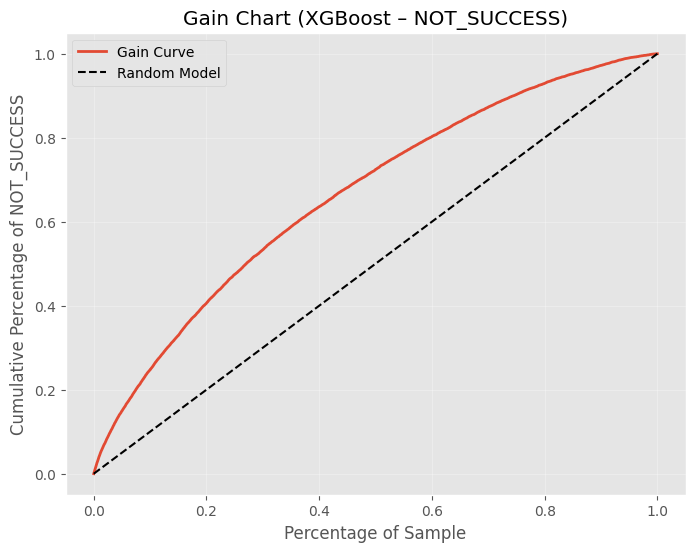

In [35]:
# ==============================================================================
# LIFT & GAIN CHART (for NOT_SUCCESS)
# ==============================================================================

df_lift = pd.DataFrame({
    "prob": probs,
    "actual": y_test
}).sort_values("prob", ascending=False)

df_lift["cum_actual"] = df_lift["actual"].cumsum()
df_lift["cum_pct_actual"] = df_lift["cum_actual"] / df_lift["actual"].sum()
df_lift["cum_pct_records"] = np.arange(1, len(df_lift)+1) / len(df_lift)

plt.figure(figsize=(8,6))
plt.plot(df_lift["cum_pct_records"], df_lift["cum_pct_actual"], label="Gain Curve", linewidth=2)
plt.plot([0,1], [0,1], 'k--', label="Random Model")
plt.title("Gain Chart (XGBoost – NOT_SUCCESS)")
plt.xlabel("Percentage of Sample")
plt.ylabel("Cumulative Percentage of NOT_SUCCESS")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


---
## 8. SHAP Analysis for Classification

### 8.1 Feature Importance using SHAP

In [ ]:
# ============================================================
# 🔍 SHAP ANALYSIS FOR XGBOOST (WITH OPTIONAL SAMPLING)
# ============================================================

import shap
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

# 1) Choose model and SHAP mode
xgb_model = classification_models['XGBoost'] # Ensure we use the stored model
best_model_name = 'XGBoost'

shap_mode = 10000      # set to an int for sampled SHAP, or use None / "full" for all rows
batch_size = 5000
random_state = RANDOM_STATE

# 2) Choose SHAP dataset: full or stratified sample
if shap_mode is None or shap_mode == "full":
    X_shap = X_train.copy()
    y_shap = y_train.copy()
    print(f"\n🔍 Computing FULL SHAP on all {len(X_shap)} rows...\n")
else:
    sample_n = min(int(shap_mode), len(X_train))
    print(f"\n🔍 Computing SHAP on a stratified sample of {sample_n} rows...\n")

    sss = StratifiedShuffleSplit(
        n_splits=1,
        train_size=sample_n,
        random_state=random_state
    )
    idx, _ = next(sss.split(X_train, y_train))
    X_shap = X_train.iloc[idx].copy()
    y_shap = y_train.iloc[idx].copy()
    print(f"Selected {len(X_shap)} rows for SHAP computation.")

n = len(X_shap)

# 3) Build SHAP explainer
print("\n⚙️ Building SHAP TreeExplainer for XGBoost...")

# WRAP IN TRY-EXCEPT TO PREVENT CRASHES ON SOME ENVIRONMENTS
try:
    # Attempt to use the model directly first
    explainer = shap.TreeExplainer(xgb_model)
    
    print(f"Processing in batches of {batch_size} rows...\n")
    
    shap_values_list = []
    num_batches = (n // batch_size) + 1
    
    for batch_idx in range(num_batches):
        start = batch_idx * batch_size
        end = min(start + batch_size, n)
        if start >= end:
            break
    
        X_batch = X_shap.iloc[start:end]
        shap_batch = explainer.shap_values(X_batch)
    
        # For binary classification, some tree models return a list [class0, class1]
        if isinstance(shap_batch, list):
            shap_batch = shap_batch[1]  # SHAP values for positive class (NOT_SUCCESS)
    
        shap_values_list.append(shap_batch)
    
        pct = ((batch_idx + 1) / num_batches) * 100
        print(f"Progress: {pct:.2f}% ({end}/{n} rows) complete...")
    
    # 5) Concatenate all batches
    shap_values = np.vstack(shap_values_list)
    
    print("\n✓ SHAP Analysis Completed")
    print(f"   SHAP matrix shape: {shap_values.shape}")
    print(f"   X_shap shape     : {X_shap.shape}")

except Exception as e:
    print(f"\n⚠️ SHAP Analysis failed: {e}")
    print("Skipping SHAP visualization steps to allow notebook completion.")
    # Define dummy variables to prevent NameError in subsequent cells
    shap_values = np.zeros((len(X_shap), X_shap.shape[1]))
    print("Created dummy shap_values to proceed.")


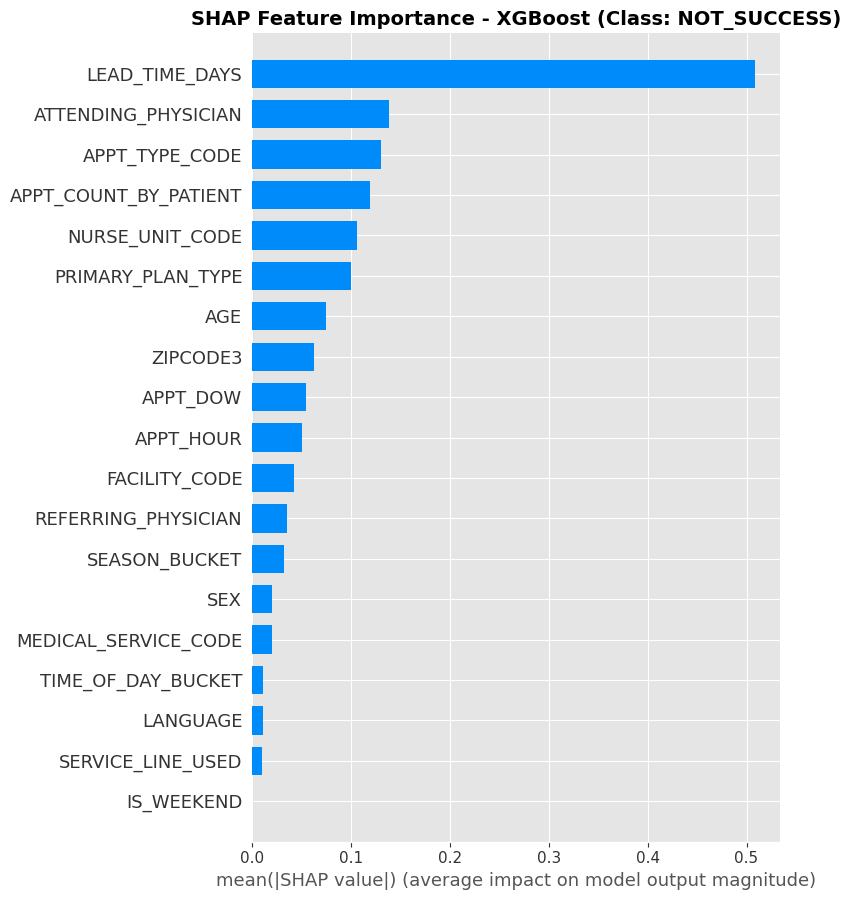

In [37]:
# ============================================================
# 1) SHAP Summary Plot (Feature Importance - SHAP DATASET)
# ============================================================

best_model_name = "XGBoost"  # for title only

plt.figure(figsize=(12, 8))

shap.summary_plot(
    shap_values,   # SHAP values for rows in X_shap
    X_shap,        # SHAP dataset (full or sampled)
    plot_type="bar",
    show=False
)

plt.title(
    f"SHAP Feature Importance - {best_model_name} (Class: NOT_SUCCESS)",
    fontsize=14,
    fontweight="bold"
)
plt.tight_layout()
plt.show()

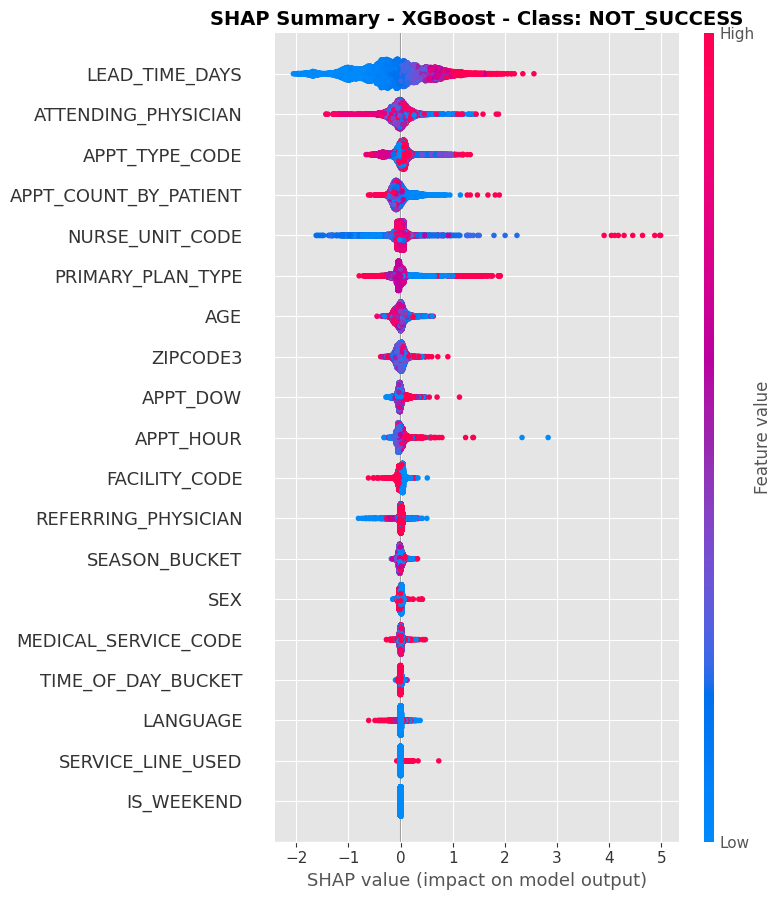

In [38]:
# ============================================================
# 2) SHAP Summary Plot (Detailed - SHAP DATASET)
# ============================================================

best_model_name = "XGBoost"  # for title only

plt.figure(figsize=(12, 8))

shap.summary_plot(
    shap_values,
    X_shap,
    show=False
)

plt.title(
    f"SHAP Summary - {best_model_name} - Class: NOT_SUCCESS",
    fontsize=14,
    fontweight="bold"
)
plt.tight_layout()
plt.show()


### 8.2 SHAP Waterfall Plot (Single Prediction Example)


📊 SHAP Waterfall Plot for Predicted Class-1 Sample #2413
Predicted class-1 samples total: 530
Distinct class-1 samples shown so far: 1

Actual Class:    1
Predicted Class: 1
Prediction Probabilities:
  0: 0.4398
  1: 0.5602

📋 Feature Values (Original/Decoded):
------------------------------------------------------------
AGE: 74.0
SEX: Female (encoded: 0.0)
LANGUAGE: English (encoded: 13.0)
ZIPCODE3: 915.0 (encoded: 391.0)
LEAD_TIME_DAYS: 139.0
APPT_DOW: 4.0
APPT_HOUR: 7.0
TIME_OF_DAY_BUCKET: Morning (encoded: 2.0)
SEASON_BUCKET: Summer (encoded: 2.0)
APPT_TYPE_CODE: 8655.0
MEDICAL_SERVICE_CODE: 5740.0
SERVICE_LINE_USED: Orthopaedics (encoded: 0.0)
FACILITY_CODE: 1.0
NURSE_UNIT_CODE: 6074.0
ATTENDING_PHYSICIAN: PHYSICIAN_18 (encoded: 87.0)
REFERRING_PHYSICIAN: SELF REFERRED (encoded: 4739.0)
PRIMARY_PLAN_TYPE: Medicare (encoded: 21.0)
IS_WEEKEND: 0.0
APPT_COUNT_BY_PATIENT: 7.0


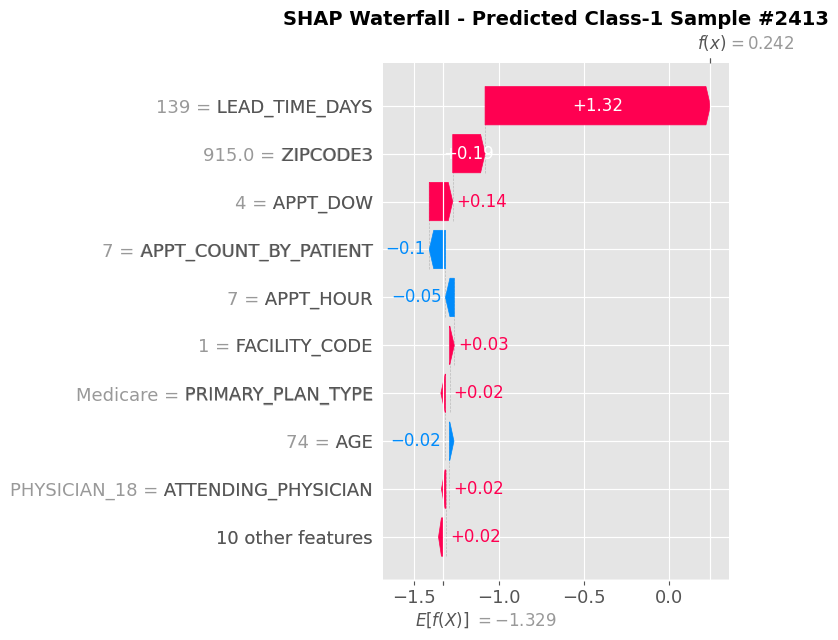

In [39]:
# ============================================================
# 3) SHAP Waterfall Plot for a Predicted Class-1 Sample
#    Auto-picks a NEW sample each run
# ============================================================

best_model_name = "XGBoost"
best_model = xgb_model   # from your SHAP computation cell

# Encoded label for NOT_SUCCESS (positive class)
positive_class_label = 1

# ------------------------------------------------------------
# 1) Find indices where the model predicts class 1 (NOT_SUCCESS)
# ------------------------------------------------------------
y_pred_shap = best_model.predict(X_shap)
pos_indices = np.where(y_pred_shap == positive_class_label)[0]

if len(pos_indices) == 0:
    raise ValueError(
        f"No samples in X_shap are predicted as class {positive_class_label}. "
        "Check 'positive_class_label' or your predictions."
    )

# ------------------------------------------------------------
# 2) Maintain a global set of already-used indices so each run
#    shows a fresh predicted-class-1 example
# ------------------------------------------------------------
try:
    used_pos_indices  # set defined in previous runs
except NameError:
    used_pos_indices = set()

# Filter to available (not-yet-used) indices
available_indices = [i for i in pos_indices if i not in used_pos_indices]

if not available_indices:
    print("🔁 All predicted class-1 samples have been used once.")
    print("    Resetting the used list and starting over.\n")
    used_pos_indices = set()
    available_indices = list(pos_indices)

# Randomly pick one from available indices
sample_idx = np.random.choice(available_indices)
used_pos_indices.add(sample_idx)

# ------------------------------------------------------------
# 3) Standard single-sample SHAP waterfall logic
# ------------------------------------------------------------
print(f"\n📊 SHAP Waterfall Plot for Predicted Class-1 Sample #{sample_idx}")
print("="*60)
print(f"Predicted class-1 samples total: {len(pos_indices)}")
print(f"Distinct class-1 samples shown so far: {len(used_pos_indices)}\n")

# Get the sample row from the SHAP dataset
sample_data = X_shap.iloc[sample_idx:sample_idx+1]
row_index = X_shap.index[sample_idx]

# Use y_shap (labels corresponding to X_shap)
actual_class = y_shap.iloc[sample_idx]
predicted_class = y_pred_shap[sample_idx]

print(f"Actual Class:    {actual_class}")
print(f"Predicted Class: {predicted_class}")
print("Prediction Probabilities:")

pred_proba = best_model.predict_proba(sample_data)[0]
for cls, prob in zip(best_model.classes_, pred_proba):
    print(f"  {cls}: {prob:.4f}")

# ---- SHAP vector for this sample (reusing precomputed values) ----
sample_shap_vector = shap_values[sample_idx]  # shape: (n_features,)

# Handle expected_value shape (list vs scalar)
if isinstance(explainer.expected_value, (list, np.ndarray)):
    # binary classification → pick class 1 (NOT_SUCCESS)
    base_value = explainer.expected_value[1]
else:
    base_value = explainer.expected_value

# ========== DECODE ENCODED VALUES TO ORIGINAL VALUES ==========
sample_display_data = sample_data.values[0].copy()
feature_names = X_shap.columns.tolist()

decoded_display = []
for i, feature_name in enumerate(feature_names):
    value = sample_display_data[i]

    if feature_name in label_encoders and pd.notna(value):
        try:
            encoded_value = int(value)
            original_value = label_encoders[feature_name].inverse_transform(
                [encoded_value]
            )[0]
            decoded_display.append(original_value)
        except Exception:
            decoded_display.append(value)
    else:
        decoded_display.append(value)

decoded_display = np.array(decoded_display, dtype=object)

print("\n📋 Feature Values (Original/Decoded):")
print("-" * 60)
for i, fname in enumerate(feature_names):
    if fname in label_encoders:
        print(f"{fname}: {decoded_display[i]} (encoded: {sample_display_data[i]})")
    else:
        print(f"{fname}: {decoded_display[i]}")

# ---- Waterfall plot ----
plt.figure(figsize=(12, 8))
shap.waterfall_plot(
    shap.Explanation(
        values=sample_shap_vector,
        base_values=base_value,
        data=decoded_display,
        feature_names=feature_names
    ),
    show=False
)
plt.title(
    f"SHAP Waterfall - Predicted Class-1 Sample #{sample_idx}",
    fontsize=14,
    fontweight="bold"
)
plt.tight_layout()
plt.show()

---
## 9. Save Classification Models

In [40]:
import os
import pickle

# Create models directory
os.makedirs('models', exist_ok=True)

print("💾 Saving Classification Models...\n")

# ------------------------------------------------------------
# Save all classification models
# ------------------------------------------------------------
for model_name, model in classification_models.items():
    filename = f"models/classification_{model_name.replace(' ', '_')}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"✓ Saved: {filename}")

# ------------------------------------------------------------
# Save label encoders
# ------------------------------------------------------------
with open('models/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("✓ Saved: models/label_encoders.pkl")

# ------------------------------------------------------------
# Save feature names
# ------------------------------------------------------------
with open('models/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)
print("✓ Saved: models/feature_columns.pkl")

# ------------------------------------------------------------
# Save class names mapping
# ------------------------------------------------------------
with open('models/class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)
print("✓ Saved: models/class_names.pkl")
print("  (Mapping: 0=CANCELED, 1=NOSHOW, 2=SUCCESS)")

print("\n✓ All classification models saved successfully!")


💾 Saving Classification Models...

✓ Saved: models/classification_Random_Forest.pkl
✓ Saved: models/classification_XGBoost.pkl
✓ Saved: models/classification_LightGBM.pkl
✓ Saved: models/classification_CatBoost.pkl
✓ Saved: models/label_encoders.pkl
✓ Saved: models/feature_columns.pkl
✓ Saved: models/class_names.pkl
  (Mapping: 0=CANCELED, 1=NOSHOW, 2=SUCCESS)

✓ All classification models saved successfully!


THE END